# Air Quality Prediction - ML Model Training

This notebook trains machine learning models to predict air quality parameters (PM2.5, PM10, NO, NO2, CO, CO2) based on:
- **Location features**: OpenStreetMap features around monitoring stations
- **Temporal features**: Time-based patterns (hour, day, month, etc.)

## Model Strategy
- Multi-output regression (predicting multiple pollutants simultaneously)
- Easy model switching for experimentation
- Designed for continuous training pipeline (Jenkins/Cronjobs)
- Modular architecture for future enhancements

## 1. Import Required Libraries

In [3]:
%pip install joblib pandas scikit-learn matplotlib seaborn

  Using cached scikit_learn-1.8.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
Using cached scikit_learn-1.8.0-cp313-cp313-macosx_12_0_arm64.whl (8.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 2.7 MB/s  0:00:02 eta 0:00:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl (274 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 3.8 MB/s  0:00:00 eta 0:00:01
Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB

In [28]:
import pandas as pd
import numpy as np
import os
import glob
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 3.0.0
NumPy version: 2.4.1


## 2. Configuration

Set paths and parameters for the training pipeline.

In [29]:
# Paths
OUTPUT_DIR = 'output'  # Directory containing station chunks
OSM_FEATURES_FILE = 'station_osm_features_filtered_110.csv'  # OSM features for 110 stations
MODEL_SAVE_DIR = 'models'  # Directory to save trained models
RESULTS_DIR = 'results'  # Directory to save results and plots

# Create directories if they don't exist
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Target pollutants to predict
TARGET_POLLUTANTS = ['PM2.5', 'PM10', 'NO', 'NO2', 'CO', 'CO2']

# Test size for train-test split
TEST_SIZE = 0.2
RANDOM_STATE = 42

print(f"Configuration:")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  OSM features file: {OSM_FEATURES_FILE}")
print(f"  Model save directory: {MODEL_SAVE_DIR}")
print(f"  Results directory: {RESULTS_DIR}")
print(f"  Target pollutants: {TARGET_POLLUTANTS}")
print(f"  Test size: {TEST_SIZE}")
print(f"  Random state: {RANDOM_STATE}")

Configuration:
  Output directory: output
  OSM features file: station_osm_features_filtered_110.csv
  Model save directory: models
  Results directory: results
  Target pollutants: ['PM2.5', 'PM10', 'NO', 'NO2', 'CO', 'CO2']
  Test size: 0.2
  Random state: 42


## 3. Load and Combine Air Quality Data

Load all chunked CSV files from the output directory and combine them into a single dataset.

In [30]:
# Find all CSV files in output directory
all_chunks = glob.glob(os.path.join(OUTPUT_DIR, '*', '*.csv'))

print(f"Found {len(all_chunks)} chunk files")
print(f"\nSample files:")
for i, file in enumerate(all_chunks[:5]):
    print(f"  {i+1}. {file}")

if len(all_chunks) > 5:
    print(f"  ... and {len(all_chunks) - 5} more files")

Found 9 chunk files

Sample files:
  1. output/AP001/AP001_chunk_2.csv
  2. output/AP001/AP001_chunk_3.csv
  3. output/AP001/AP001_chunk_1.csv
  4. output/AS001/AS001_chunk_2.csv
  5. output/AS001/AS001_chunk_1.csv
  ... and 4 more files


In [31]:
# Load and combine all chunks
print("Loading all chunk files...")
df_chunks_list = []

for i, chunk_file in enumerate(all_chunks):
    try:
        df_chunk = pd.read_csv(chunk_file)
        df_chunks_list.append(df_chunk)
        
        if (i + 1) % 10 == 0:
            print(f"  Loaded {i + 1}/{len(all_chunks)} files...")
    except Exception as e:
        print(f"  Error loading {chunk_file}: {e}")

# Combine all chunks
df_aq = pd.concat(df_chunks_list, ignore_index=True)

print(f"\nCombined dataset:")
print(f"  Total rows: {len(df_aq):,}")
print(f"  Total columns: {len(df_aq.columns)}")
print(f"  Memory usage: {df_aq.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nColumns: {df_aq.columns.tolist()}")

# Display first few rows
df_aq.head()

Loading all chunk files...

Combined dataset:
  Total rows: 69,839
  Total columns: 42
  Memory usage: 124.25 MB

Columns: ['StationId', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket', 'aeroway', 'amenity', 'barrier', 'boundary', 'building', 'craft', 'emergency', 'healthcare', 'highway', 'historic', 'industrial', 'landuse', 'leisure', 'man_made', 'military', 'natural', 'office', 'place', 'power', 'public_transport', 'railway', 'shop', 'sport', 'tourism', 'water', 'waterway']


,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,office,place,power,public_transport,railway,shop,sport,tourism,water,waterway
0,AP001,2019-01-15 09:00:00,120.00,216.75,7.92,60.95,38.85,17.93,1.15,12.40,...,government,NaN,line,platform,NaN,NaN,NaN,NaN,NaN,drain
1,AP001,2019-01-15 10:00:00,123.00,207.00,4.28,51.00,30.60,18.43,1.12,17.75,...,government,NaN,line,platform,NaN,NaN,NaN,NaN,NaN,drain
2,AP001,2019-01-15 11:00:00,108.25,183.75,1.88,43.10,24.43,18.40,0.91,20.60,...,government,NaN,line,platform,NaN,NaN,NaN,NaN,NaN,drain
3,AP001,2019-01-15 12:00:00,98.75,146.50,2.05,39.00,22.40,18.60,1.01,24.62,...,government,NaN,line,platform,NaN,NaN,NaN,NaN,NaN,drain
4,AP001,2019-01-15 13:00:00,108.25,162.25,2.42,42.60,24.65,18.98,1.10,77.67,...,government,NaN,line,platform,NaN,NaN,NaN,NaN,NaN,drain


## 4. Load OSM Features

Load the OpenStreetMap features for the 110 stations.

In [32]:
# Load OSM features
df_osm = pd.read_csv(OSM_FEATURES_FILE)

print(f"OSM Features dataset:")
print(f"  Total stations: {len(df_osm)}")
print(f"  Total features: {len(df_osm.columns)}")
print(f"\nColumns: {df_osm.columns.tolist()}")

# Display first few rows
df_osm.head()

OSM Features dataset:
  Total stations: 96
  Total features: 33

Columns: ['station_id', 'original_station_id', 'station_name', 'latitude', 'longitude', '_total_elements', '_unique_feature_types', 'aeroway', 'amenity', 'barrier', 'boundary', 'building', 'craft', 'emergency', 'healthcare', 'highway', 'historic', 'industrial', 'landuse', 'leisure', 'man_made', 'military', 'natural', 'office', 'place', 'power', 'public_transport', 'railway', 'shop', 'sport', 'tourism', 'water', 'waterway']


,station_id,original_station_id,station_name,latitude,longitude,_total_elements,_unique_feature_types,aeroway,amenity,barrier,...,office,place,power,public_transport,railway,shop,sport,tourism,water,waterway
0,TN005,site_5094,"SIDCO Kurichi, Coimbatore - TNPCB",10.942451,76.978996,22953,6,NaN,"college,fuel",gate,...,NaN,NaN,NaN,NaN,rail,NaN,NaN,NaN,NaN,NaN
1,DL034,site_119,"Sirifort, Delhi - CPCB",28.550425,77.215938,11277,18,NaN,"bench,cafe,charging_station,clinic,college,con...","bollard,city_wall,cycle_barrier,entrance,fence...",...,"company,diplomatic,government,lawyer","neighbourhood,suburb","pole,substation",platform,NaN,"art,bakery,beauty,boutique,clothes,electrical,...","basketball,cricket,soccer,squash;badminton,ten...","gallery,museum",NaN,NaN
2,DL017,site_5395,"Lodhi Road, Delhi - IITM",28.588333,77.221667,12472,20,NaN,"arts_centre,atm,bank,bar,bicycle_rental,cafe,c...","fence,gate,kerb,lift_gate,wall",...,"association,company,diplomatic,government,ngo",neighbourhood,generator,platform,NaN,"bakery,bicycle,books,convenience,dairy,florist",tennis,"artwork,attraction",pond,NaN
3,MH014,site_5115,"Worli, Mumbai - MPCB",18.993616,72.812811,312159,18,NaN,"cafe,crematorium,fast_food,fuel,planetarium,sc...",gate,...,"financial,government","island,locality,neighbourhood,sea,state",NaN,"platform,station,stop_area,stop_position","station,stop,subway",mall,"horse_racing,swimming","attraction,museum",canal,"drain,lock_gate"
4,TN004,site_288,"Velachery Res. Area, Chennai - CPCB",13.005219,80.239812,12305,17,NaN,"atm,bench,bicycle_parking,cafe,college,drinkin...","block,gate,hedge,lift_gate,median,wall",...,NaN,neighbourhood,NaN,"platform,stop_position",NaN,"stationery,tea","cricket,racquet,tennis","apartment,artwork,attraction,zoo","lake,pond",stream


## 5. Data Preprocessing

### 5.1 Parse DateTime and Create Temporal Features

In [33]:
# Parse datetime column (assuming column name is 'Datetime' or 'datetime')
datetime_col = None
for col in df_aq.columns:
    if col.lower() in ['datetime', 'date', 'timestamp', 'time']:
        datetime_col = col
        break

if datetime_col:
    print(f"Found datetime column: {datetime_col}")
    df_aq[datetime_col] = pd.to_datetime(df_aq[datetime_col])
    
    # Create temporal features
    df_aq['year'] = df_aq[datetime_col].dt.year
    df_aq['month'] = df_aq[datetime_col].dt.month
    df_aq['day'] = df_aq[datetime_col].dt.day
    df_aq['hour'] = df_aq[datetime_col].dt.hour
    df_aq['day_of_week'] = df_aq[datetime_col].dt.dayofweek  # Monday=0, Sunday=6
    df_aq['day_of_year'] = df_aq[datetime_col].dt.dayofyear
    df_aq['week_of_year'] = df_aq[datetime_col].dt.isocalendar().week
    df_aq['is_weekend'] = (df_aq['day_of_week'] >= 5).astype(int)  # 1 if weekend, 0 otherwise
    
    # Cyclical encoding for hour (to capture 23:00 and 00:00 proximity)
    df_aq['hour_sin'] = np.sin(2 * np.pi * df_aq['hour'] / 24)
    df_aq['hour_cos'] = np.cos(2 * np.pi * df_aq['hour'] / 24)
    
    # Cyclical encoding for month
    df_aq['month_sin'] = np.sin(2 * np.pi * df_aq['month'] / 12)
    df_aq['month_cos'] = np.cos(2 * np.pi * df_aq['month'] / 12)
    
    print(f"\nTemporal features created:")
    print(f"  - year, month, day, hour")
    print(f"  - day_of_week, day_of_year, week_of_year")
    print(f"  - is_weekend")
    print(f"  - hour_sin, hour_cos (cyclical encoding)")
    print(f"  - month_sin, month_cos (cyclical encoding)")
else:
    print("Warning: No datetime column found!")
    print(f"Available columns: {df_aq.columns.tolist()}")

# Display sample with temporal features
df_aq.head()

Found datetime column: Datetime

Temporal features created:
  - year, month, day, hour
  - day_of_week, day_of_year, week_of_year
  - is_weekend
  - hour_sin, hour_cos (cyclical encoding)
  - month_sin, month_cos (cyclical encoding)


,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,day,hour,day_of_week,day_of_year,week_of_year,is_weekend,hour_sin,hour_cos,month_sin,month_cos
0,AP001,2019-01-15 09:00:00,120.00,216.75,7.92,60.95,38.85,17.93,1.15,12.40,...,15,9,1,15,3,0,7.071068e-01,-0.707107,0.5,0.866025
1,AP001,2019-01-15 10:00:00,123.00,207.00,4.28,51.00,30.60,18.43,1.12,17.75,...,15,10,1,15,3,0,5.000000e-01,-0.866025,0.5,0.866025
2,AP001,2019-01-15 11:00:00,108.25,183.75,1.88,43.10,24.43,18.40,0.91,20.60,...,15,11,1,15,3,0,2.588190e-01,-0.965926,0.5,0.866025
3,AP001,2019-01-15 12:00:00,98.75,146.50,2.05,39.00,22.40,18.60,1.01,24.62,...,15,12,1,15,3,0,1.224647e-16,-1.000000,0.5,0.866025
4,AP001,2019-01-15 13:00:00,108.25,162.25,2.42,42.60,24.65,18.98,1.10,77.67,...,15,13,1,15,3,0,-2.588190e-01,-0.965926,0.5,0.866025


### 5.2 Merge Air Quality Data with OSM Features

In [34]:
# Find station ID column in air quality data
station_id_col = None
for col in df_aq.columns:
    if 'station' in col.lower() and 'id' in col.lower():
        station_id_col = col
        break

if not station_id_col:
    # Try just 'StationId' or similar
    for col in df_aq.columns:
        if col.lower() in ['stationid', 'station_id', 'station']:
            station_id_col = col
            break

print(f"Station ID column in air quality data: {station_id_col}")
print(f"Unique stations in AQ data: {df_aq[station_id_col].nunique()}")
print(f"Unique stations in OSM data: {df_osm['station_id'].nunique()}")

# Merge datasets
df_merged = df_aq.merge(
    df_osm,
    left_on=station_id_col,
    right_on='station_id',
    how='inner'
)

print(f"\nMerged dataset:")
print(f"  Total rows: {len(df_merged):,}")
print(f"  Total columns: {len(df_merged.columns)}")
print(f"  Stations with data: {df_merged[station_id_col].nunique()}")

df_merged.head()

Station ID column in air quality data: StationId
Unique stations in AQ data: 3
Unique stations in OSM data: 93

Merged dataset:
  Total rows: 69,839
  Total columns: 87
  Stations with data: 3


,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,office_y,place_y,power_y,public_transport_y,railway_y,shop_y,sport_y,tourism_y,water_y,waterway_y
0,AP001,2019-01-15 09:00:00,120.00,216.75,7.92,60.95,38.85,17.93,1.15,12.40,...,government,NaN,line,platform,NaN,NaN,NaN,NaN,NaN,drain
1,AP001,2019-01-15 10:00:00,123.00,207.00,4.28,51.00,30.60,18.43,1.12,17.75,...,government,NaN,line,platform,NaN,NaN,NaN,NaN,NaN,drain
2,AP001,2019-01-15 11:00:00,108.25,183.75,1.88,43.10,24.43,18.40,0.91,20.60,...,government,NaN,line,platform,NaN,NaN,NaN,NaN,NaN,drain
3,AP001,2019-01-15 12:00:00,98.75,146.50,2.05,39.00,22.40,18.60,1.01,24.62,...,government,NaN,line,platform,NaN,NaN,NaN,NaN,NaN,drain
4,AP001,2019-01-15 13:00:00,108.25,162.25,2.42,42.60,24.65,18.98,1.10,77.67,...,government,NaN,line,platform,NaN,NaN,NaN,NaN,NaN,drain


### 5.3 Prepare Feature Matrix and Target Variables

In [35]:
# Define columns to exclude from features
exclude_cols = [
    station_id_col,
    'station_id',
    'original_station_id',
    'station_name',
    'latitude',
    'longitude',
    datetime_col if datetime_col else 'datetime',
    '_total_elements',
    '_unique_feature_types'
] + TARGET_POLLUTANTS

# Get feature columns (all columns except excluded ones and target pollutants)
feature_cols = [col for col in df_merged.columns if col not in exclude_cols]

print(f"Feature columns ({len(feature_cols)}):")
print(feature_cols)

# Check which target pollutants are available
available_targets = [col for col in TARGET_POLLUTANTS if col in df_merged.columns]
missing_targets = [col for col in TARGET_POLLUTANTS if col not in df_merged.columns]

print(f"\nAvailable target pollutants ({len(available_targets)}): {available_targets}")
if missing_targets:
    print(f"Missing target pollutants ({len(missing_targets)}): {missing_targets}")

# Use available targets
TARGET_POLLUTANTS = available_targets

Feature columns (73):
['NOx', 'NH3', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket', 'aeroway_x', 'amenity_x', 'barrier_x', 'boundary_x', 'building_x', 'craft_x', 'emergency_x', 'healthcare_x', 'highway_x', 'historic_x', 'industrial_x', 'landuse_x', 'leisure_x', 'man_made_x', 'military_x', 'natural_x', 'office_x', 'place_x', 'power_x', 'public_transport_x', 'railway_x', 'shop_x', 'sport_x', 'tourism_x', 'water_x', 'waterway_x', 'year', 'month', 'day', 'hour', 'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'aeroway_y', 'amenity_y', 'barrier_y', 'boundary_y', 'building_y', 'craft_y', 'emergency_y', 'healthcare_y', 'highway_y', 'historic_y', 'industrial_y', 'landuse_y', 'leisure_y', 'man_made_y', 'military_y', 'natural_y', 'office_y', 'place_y', 'power_y', 'public_transport_y', 'railway_y', 'shop_y', 'sport_y', 'tourism_y', 'water_y', 'waterway_y']

Available target pollutants (5): ['PM2.5', 'PM10', 'NO', 'NO

In [36]:
# Create feature matrix X and target matrix y
X = df_merged[feature_cols].copy()
y = df_merged[TARGET_POLLUTANTS].copy()

print(f"Feature matrix X shape: {X.shape}")
print(f"Target matrix y shape: {y.shape}")

# Check for missing values
print(f"\nMissing values in X:")
missing_x = X.isnull().sum()
print(missing_x[missing_x > 0])

print(f"\nMissing values in y:")
missing_y = y.isnull().sum()
print(missing_y[missing_y > 0])

Feature matrix X shape: (69839, 73)
Target matrix y shape: (69839, 5)

Missing values in X:
NOx                    6643
NH3                   11555
SO2                   13211
O3                    11672
Benzene                7806
Toluene               19151
Xylene                30641
AQI                   11956
AQI_Bucket            11956
aeroway_x             47055
boundary_x            22784
craft_x               69839
emergency_x           69839
healthcare_x          34786
historic_x            57837
industrial_x          69839
man_made_x            34786
military_x            69839
natural_x             12002
place_x               22784
power_x               12002
public_transport_x    12002
railway_x             57837
shop_x                22784
sport_x               34786
tourism_x             22784
water_x               34786
waterway_x            12002
aeroway_y             47055
boundary_y            22784
craft_y               69839
emergency_y           69839
healthcare_y

### 5.4 Analyze Missing Data Patterns

Before handling missing values, let's understand the missingness patterns in our target variables.

In [37]:
# Analyze missing data patterns in target variables
print("Missing Data Analysis for Target Pollutants")
print("=" * 80)

for pollutant in TARGET_POLLUTANTS:
    missing_count = y[pollutant].isnull().sum()
    missing_pct = (missing_count / len(y)) * 100
    available_count = len(y) - missing_count
    print(f"{pollutant:<10}: {missing_count:>8,} missing ({missing_pct:>5.2f}%) | {available_count:>8,} available")

# Check how many rows have ALL pollutants available
all_available = (~y.isnull()).all(axis=1).sum()
all_available_pct = (all_available / len(y)) * 100
print(f"\n{'ALL':<10}: {len(y) - all_available:>8,} rows with ANY missing ({100-all_available_pct:>5.2f}%) | {all_available:>8,} rows complete ({all_available_pct:>5.2f}%)")

# Check how many rows have at least ONE pollutant available
any_available = (~y.isnull()).any(axis=1).sum()
any_available_pct = (any_available / len(y)) * 100
print(f"{'AT LEAST ONE':<10}: {any_available:>8,} rows with data ({any_available_pct:>5.2f}%)")

# Show correlation of missingness
print("\nMissingness Correlation Matrix:")
print("(1.0 = always missing together, 0.0 = independent)")
missing_corr = y.isnull().corr()
print(missing_corr.round(2))

Missing Data Analysis for Target Pollutants
PM2.5     :   12,891 missing (18.46%) |   56,948 available
PM10      :   12,377 missing (17.72%) |   57,462 available
NO        :   11,550 missing (16.54%) |   58,289 available
NO2       :   11,838 missing (16.95%) |   58,001 available
CO        :    7,685 missing (11.00%) |   62,154 available

ALL       :   15,279 rows with ANY missing (21.88%) |   54,560 rows complete (78.12%)
AT LEAST ONE:   63,301 rows with data (90.64%)

Missingness Correlation Matrix:
(1.0 = always missing together, 0.0 = independent)
       PM2.5  PM10    NO   NO2    CO
PM2.5   1.00  0.91  0.91  0.89  0.62
PM10    0.91  1.00  0.93  0.92  0.62
NO      0.91  0.93  1.00  0.97  0.65
NO2     0.89  0.92  0.97  1.00  0.64
CO      0.62  0.62  0.65  0.64  1.00


### 5.5 Handle Missing Values and Data Types

In [38]:
# Separate numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")
if categorical_cols:
    print(f"Categorical columns: {categorical_cols}")

# Handle categorical features (OSM features with comma-separated values)
if categorical_cols:
    print("\nProcessing categorical features (counting unique values)...")
    for col in categorical_cols:
        X[f'{col}_count'] = X[col].fillna('').apply(lambda x: len(str(x).split(',')) if x else 0)
        X = X.drop(columns=[col])
    
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    print(f"Features after processing: {len(numeric_cols)}")

# Impute missing values - ensure all columns are actually numeric
# Force conversion to numeric and drop any columns that can't be converted
X_numeric = X.select_dtypes(include=[np.number]).copy()

print(f"\nBefore imputation: {X_numeric.shape}")

imputer_X = SimpleImputer(strategy='median')
X_imputed_array = imputer_X.fit_transform(X_numeric)

print(f"After imputation array shape: {X_imputed_array.shape}")

# Create DataFrame - use actual shape from the imputed array
X_imputed = pd.DataFrame(
    X_imputed_array,
    columns=X_numeric.columns[:X_imputed_array.shape[1]],  # Use only as many column names as we have columns
    index=X.index
)

print(f"\nFeature matrix after imputation: {X_imputed.shape}")

Numeric features: 24
Categorical features: 49
Categorical columns: ['AQI_Bucket', 'aeroway_x', 'amenity_x', 'barrier_x', 'boundary_x', 'building_x', 'healthcare_x', 'highway_x', 'historic_x', 'landuse_x', 'leisure_x', 'man_made_x', 'natural_x', 'office_x', 'place_x', 'power_x', 'public_transport_x', 'railway_x', 'shop_x', 'sport_x', 'tourism_x', 'water_x', 'waterway_x', 'aeroway_y', 'amenity_y', 'barrier_y', 'boundary_y', 'building_y', 'craft_y', 'emergency_y', 'healthcare_y', 'highway_y', 'historic_y', 'industrial_y', 'landuse_y', 'leisure_y', 'man_made_y', 'military_y', 'natural_y', 'office_y', 'place_y', 'power_y', 'public_transport_y', 'railway_y', 'shop_y', 'sport_y', 'tourism_y', 'water_y', 'waterway_y']

Processing categorical features (counting unique values)...
Features after processing: 73

Before imputation: (69839, 73)
After imputation array shape: (69839, 69)

Feature matrix after imputation: (69839, 69)


### 5.6 Handle Missing Target Values - Strategy Selection

**Choose your strategy** by setting the `MISSING_TARGET_STRATEGY` variable:

**Strategy Options:**
1. **'impute'** - Fill missing values with forward/backward fill then median (RECOMMENDED - keeps all data)
2. **'drop_all'** - Drop rows with ANY missing targets (most data loss, cleanest dataset)
3. **'drop_majority'** - Drop rows missing MORE THAN 50% of targets (balanced approach)

**Trade-offs:**
- Imputation: Keeps all data but introduces estimation error
- Drop all: Cleanest but loses ~50% of data
- Drop majority: Keeps rows with at least some real measurements

In [39]:
# ============================================================================
# CHANGE THIS VARIABLE TO SELECT MISSING DATA STRATEGY
# ============================================================================
MISSING_TARGET_STRATEGY = 'impute'  # Options: 'impute', 'drop_all', 'drop_majority'
# ============================================================================

print(f"Selected strategy: {MISSING_TARGET_STRATEGY}")
print("=" * 80)

if MISSING_TARGET_STRATEGY == 'impute':
    print("Strategy: IMPUTE missing target values")
    print("  - Forward fill (use previous hour's value)")
    print("  - Backward fill (use next hour's value)")
    print("  - Median fill (for remaining NaNs)")
    print("  - Keeps ALL data - no rows dropped!")
    
    # Sort by datetime to ensure proper forward/backward fill
    if datetime_col and datetime_col in df_merged.columns:
        # Get the original order indices
        original_index = y.index
        
        # Create a temporary dataframe with datetime for proper sorting
        y_with_time = y.copy()
        y_with_time['_datetime'] = df_merged.loc[y.index, datetime_col]
        y_with_time['_station'] = df_merged.loc[y.index, station_id_col]
        
        # Sort by station and time
        y_sorted = y_with_time.sort_values(['_station', '_datetime'])
        
        # Apply imputation separately for each station
        y_imputed_list = []
        for station in y_sorted['_station'].unique():
            station_mask = y_sorted['_station'] == station
            y_station = y_sorted[station_mask][TARGET_POLLUTANTS].copy()
            
            # Forward fill, then backward fill, then median
            y_station = y_station.ffill().bfill()
            
            # Fill any remaining NaNs with median
            for col in TARGET_POLLUTANTS:
                if y_station[col].isnull().any():
                    median_val = y_station[col].median()
                    if pd.isna(median_val):  # If still NaN, use global median
                        median_val = y[col].median()
                    y_station[col].fillna(median_val, inplace=True)
            
            y_imputed_list.append(y_station)
        
        # Combine and restore original order
        y_imputed_sorted = pd.concat(y_imputed_list)
        y_imputed = y_imputed_sorted.reindex(original_index)
    else:
        # Simple imputation without time-based ordering
        y_imputed = y.copy()
        for col in TARGET_POLLUTANTS:
            median_val = y[col].median()
            y_imputed[col].fillna(median_val, inplace=True)
    
    X_clean = X_imputed.copy()
    y_clean = y_imputed.copy()
    
    print(f"\nResult:")
    print(f"  Rows kept: {len(X_clean):,} (100.0%)")
    print(f"  Rows dropped: 0")
    
elif MISSING_TARGET_STRATEGY == 'drop_all':
    print("Strategy: DROP rows with ANY missing target values")
    print("  - Most conservative approach")
    print("  - Highest data loss but cleanest dataset")
    print("  - Only keeps rows with ALL pollutants measured")
    
    mask = ~y.isnull().any(axis=1)
    X_clean = X_imputed[mask].copy()
    y_clean = y[mask].copy()
    
    rows_kept = len(X_clean)
    rows_dropped = len(X_imputed) - rows_kept
    pct_kept = (rows_kept / len(X_imputed)) * 100
    
    print(f"\nResult:")
    print(f"  Rows kept: {rows_kept:,} ({pct_kept:.2f}%)")
    print(f"  Rows dropped: {rows_dropped:,} ({100-pct_kept:.2f}%)")
    
elif MISSING_TARGET_STRATEGY == 'drop_majority':
    print("Strategy: DROP rows missing MORE THAN 50% of targets")
    print("  - Balanced approach")
    print("  - Keeps rows with at least 3 out of 6 pollutants")
    print("  - Moderate data retention")
    
    # Count non-null values per row
    non_null_counts = y.notna().sum(axis=1)
    threshold = len(TARGET_POLLUTANTS) / 2
    
    mask = non_null_counts > threshold
    X_clean = X_imputed[mask].copy()
    y_clean = y[mask].copy()
    
    # Impute remaining NaNs with median
    for col in TARGET_POLLUTANTS:
        if y_clean[col].isnull().any():
            median_val = y_clean[col].median()
            y_clean[col].fillna(median_val, inplace=True)
    
    rows_kept = len(X_clean)
    rows_dropped = len(X_imputed) - rows_kept
    pct_kept = (rows_kept / len(X_imputed)) * 100
    
    print(f"\nResult:")
    print(f"  Rows kept: {rows_kept:,} ({pct_kept:.2f}%)")
    print(f"  Rows dropped: {rows_dropped:,} ({100-pct_kept:.2f}%)")
    print(f"  Remaining NaNs imputed with median")

else:
    raise ValueError(f"Invalid strategy: {MISSING_TARGET_STRATEGY}. Choose 'impute', 'drop_all', or 'drop_majority'")

print(f"\nFinal dataset:")
print(f"  X shape: {X_clean.shape}")
print(f"  y shape: {y_clean.shape}")
print(f"  Missing values in y: {y_clean.isnull().sum().sum()}")

Selected strategy: impute
Strategy: IMPUTE missing target values
  - Forward fill (use previous hour's value)
  - Backward fill (use next hour's value)
  - Median fill (for remaining NaNs)
  - Keeps ALL data - no rows dropped!

Result:
  Rows kept: 69,839 (100.0%)
  Rows dropped: 0

Final dataset:
  X shape: (69839, 69)
  y shape: (69839, 5)
  Missing values in y: 0


### 5.7 Train-Test Split

In [40]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_clean,
    y_clean,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

print(f"Dataset split:")
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Testing set: {X_test.shape[0]:,} samples")
print(f"  Features: {X_train.shape[1]}")
print(f"  Targets: {y_train.shape[1]}")

Dataset split:
  Training set: 55,871 samples
  Testing set: 13,968 samples
  Features: 69
  Targets: 5


### 5.8 Feature Scaling

In [41]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")
print(f"  Mean: {X_train_scaled.mean():.6f}")
print(f"  Std: {X_train_scaled.std():.6f}")

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

Features scaled using StandardScaler
  Mean: -0.000000
  Std: 0.970582


## 6. Model Definition and Selection

Define multiple ML models and create a mechanism for easy switching between them.

In [72]:
# Define available models
MODELS = {
    'linear_regression': {
        'model': MultiOutputRegressor(LinearRegression()),
        'description': 'Linear Regression - Simple baseline model',
        'use_scaling': True,
        'supports_warm_start': False  # Does not support incremental training
    },
    'ridge': {
        'model': MultiOutputRegressor(Ridge(alpha=1.0, random_state=RANDOM_STATE)),
        'description': 'Ridge Regression - L2 regularization',
        'use_scaling': True,
        'supports_warm_start': False  # Does not support incremental training
    },
    'lasso': {
        'model': MultiOutputRegressor(Lasso(alpha=1.0, random_state=RANDOM_STATE)),
        'description': 'Lasso Regression - L1 regularization with feature selection',
        'use_scaling': True,
        'supports_warm_start': False  # Does not support incremental training
    },
    'decision_tree': {
        'model': MultiOutputRegressor(DecisionTreeRegressor(random_state=RANDOM_STATE)),
        'description': 'Decision Tree - Non-linear, interpretable',
        'use_scaling': False,
        'supports_warm_start': False  # Does not support incremental training (will retrain from scratch)
    },
    'random_forest': {
        'model': MultiOutputRegressor(
            RandomForestRegressor(
                n_estimators=100,
                max_depth=15,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=RANDOM_STATE,
                n_jobs=-1
            )
        ),
        'description': 'Random Forest - Ensemble of decision trees, robust to overfitting',
        'use_scaling': False,
        'supports_warm_start': True  # Supports incremental training with warm_start=True
    },
    'gradient_boosting': {
        'model': MultiOutputRegressor(
            GradientBoostingRegressor(
                n_estimators=100,
                max_depth=5,
                learning_rate=0.1,
                random_state=RANDOM_STATE
            )
        ),
        'description': 'Gradient Boosting - Sequential ensemble, high accuracy',
        'use_scaling': False,
        'supports_warm_start': True  # Supports incremental training with warm_start=True
    }
}

print("Available Models:")
print("=" * 80)
for i, (model_name, model_info) in enumerate(MODELS.items(), 1):
    print(f"{i}. {model_name}")
    print(f"   {model_info['description']}")
    print(f"   Uses scaling: {model_info['use_scaling']}")
    print(f"   Supports incremental training (warm_start): {model_info['supports_warm_start']}")
    print()

Available Models:
1. linear_regression
   Linear Regression - Simple baseline model
   Uses scaling: True
   Supports incremental training (warm_start): False

2. ridge
   Ridge Regression - L2 regularization
   Uses scaling: True
   Supports incremental training (warm_start): False

3. lasso
   Lasso Regression - L1 regularization with feature selection
   Uses scaling: True
   Supports incremental training (warm_start): False

4. decision_tree
   Decision Tree - Non-linear, interpretable
   Uses scaling: False
   Supports incremental training (warm_start): False

5. random_forest
   Random Forest - Ensemble of decision trees, robust to overfitting
   Uses scaling: False
   Supports incremental training (warm_start): True

6. gradient_boosting
   Gradient Boosting - Sequential ensemble, high accuracy
   Uses scaling: False
   Supports incremental training (warm_start): True



## 7. Training and Evaluation Functions

In [43]:
def train_model(model_name, model_config, X_train_raw, X_train_sc, X_test_raw, X_test_sc, y_train, y_test):
    """
    Train a model and evaluate its performance.
    
    Args:
        model_name: Name of the model
        model_config: Model configuration dictionary
        X_train_raw: Unscaled training features
        X_train_sc: Scaled training features
        X_test_raw: Unscaled test features
        X_test_sc: Scaled test features
        y_train: Training targets
        y_test: Testing targets
    
    Returns:
        Dictionary with trained model and metrics
    """
    print(f"\nTraining: {model_name}")
    print("=" * 80)
    print(f"Description: {model_config['description']}")
    
    # Select appropriate data (scaled or unscaled)
    X_tr = X_train_sc if model_config['use_scaling'] else X_train_raw
    X_te = X_test_sc if model_config['use_scaling'] else X_test_raw
    
    # Train model
    start_time = datetime.now()
    model = model_config['model']
    model.fit(X_tr, y_train)
    training_time = (datetime.now() - start_time).total_seconds()
    
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Make predictions
    y_train_pred = model.predict(X_tr)
    y_test_pred = model.predict(X_te)
    
    # Calculate metrics for each pollutant
    results = {
        'model_name': model_name,
        'model': model,
        'training_time': training_time,
        'use_scaling': model_config['use_scaling'],
        'metrics': {}
    }
    
    print("\nPerformance Metrics:")
    print("-" * 80)
    print(f"{'Pollutant':<10} {'MAE':<12} {'RMSE':<12} {'R²':<12} {'Train R²':<12}")
    print("-" * 80)
    
    for i, pollutant in enumerate(TARGET_POLLUTANTS):
        # Test metrics
        mae = mean_absolute_error(y_test.iloc[:, i], y_test_pred[:, i])
        rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_test_pred[:, i]))
        r2 = r2_score(y_test.iloc[:, i], y_test_pred[:, i])
        
        # Train R² (to check overfitting)
        r2_train = r2_score(y_train.iloc[:, i], y_train_pred[:, i])
        
        results['metrics'][pollutant] = {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'R2_train': r2_train
        }
        
        print(f"{pollutant:<10} {mae:<12.4f} {rmse:<12.4f} {r2:<12.4f} {r2_train:<12.4f}")
    
    # Overall metrics (average across all pollutants)
    avg_mae = np.mean([m['MAE'] for m in results['metrics'].values()])
    avg_rmse = np.mean([m['RMSE'] for m in results['metrics'].values()])
    avg_r2 = np.mean([m['R2'] for m in results['metrics'].values()])
    avg_r2_train = np.mean([m['R2_train'] for m in results['metrics'].values()])
    
    print("-" * 80)
    print(f"{'AVERAGE':<10} {avg_mae:<12.4f} {avg_rmse:<12.4f} {avg_r2:<12.4f} {avg_r2_train:<12.4f}")
    print("-" * 80)
    
    results['metrics']['AVERAGE'] = {
        'MAE': avg_mae,
        'RMSE': avg_rmse,
        'R2': avg_r2,
        'R2_train': avg_r2_train
    }
    
    return results

print("Training function defined successfully!")

Training function defined successfully!


In [44]:
# Verify no NaN values remain before training
print("Pre-training data validation:")
print("=" * 80)

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Check for NaN in X
X_train_nans = X_train.isnull().sum().sum()
X_test_nans = X_test.isnull().sum().sum()
print(f"\nNaNs in X_train: {X_train_nans}")
print(f"NaNs in X_test: {X_test_nans}")

# Check for NaN in y
y_train_nans = y_train.isnull().sum().sum()
y_test_nans = y_test.isnull().sum().sum()
print(f"NaNs in y_train: {y_train_nans}")
print(f"NaNs in y_test: {y_test_nans}")

# If NaNs found in y, apply emergency fix
if y_train_nans > 0 or y_test_nans > 0:
    print("\n⚠️  WARNING: NaN values found in target variables!")
    print("Applying emergency median imputation...")
    
    # Create copies and fill
    y_train = y_train.copy()
    y_test = y_test.copy()
    
    for col in y_train.columns:
        if y_train[col].isnull().any():
            median_val = y_train[col].median()
            if pd.isna(median_val):
                median_val = 0  # Fallback if entire column is NaN
            y_train[col] = y_train[col].fillna(median_val)
            print(f"  Filled {col} in y_train with median: {median_val:.2f}")
    
    for col in y_test.columns:
        if y_test[col].isnull().any():
            median_val = y_test[col].median()
            if pd.isna(median_val):
                median_val = y_train[col].median()  # Use train median
            y_test[col] = y_test[col].fillna(median_val)
            print(f"  Filled {col} in y_test with median: {median_val:.2f}")
    
    print("\n✓ Emergency imputation complete")
    print(f"Final NaNs in y_train: {y_train.isnull().sum().sum()}")
    print(f"Final NaNs in y_test: {y_test.isnull().sum().sum()}")
else:
    print("\n✓ All data validated - no NaN values found")

print("=" * 80)
print("Ready for training!\n")

Pre-training data validation:

X_train shape: (55871, 69)
X_test shape: (13968, 69)
y_train shape: (55871, 5)
y_test shape: (13968, 5)

NaNs in X_train: 0
NaNs in X_test: 0
NaNs in y_train: 0
NaNs in y_test: 0

✓ All data validated - no NaN values found
Ready for training!



## 8. Model Training - Manual Selection

**⚠️ DEPRECATED - NOT SUPPORTED**

This manual single-model selection approach is no longer supported. Please use one of the following instead:

**Option 1: Train All Models (Recommended)**
- Use Section 10 "Train All Models" to train all 6 models simultaneously
- Automatically saves all models with performance comparisons
- Best for initial training or when you want to compare all models

**Option 2: Incremental Training (For Updating Models)**
- Use Section 12 "Incremental Training (Fine-Tuning)" to update existing models
- Automatically loads and fine-tunes ALL previously trained models
- Memory efficient - only requires new data
- Best for continuous learning and model updates

The single-model manual approach below is kept for reference only but should not be used.

In [ ]:
# ============================================================================
# ⚠️ DEPRECATED - NOT SUPPORTED
# This single-model training approach is no longer supported.
# Please use Section 10 (Train All Models) or Section 12 (Incremental Training)
# ============================================================================

# SELECTED_MODEL = 'random_forest'  # <-- DEPRECATED - DO NOT USE

print("=" * 80)
print("⚠️  WARNING: Manual single-model selection is DEPRECATED")
print("=" * 80)
print("\nPlease use one of the following instead:")
print("\n1. Section 10: Train All Models")
print("   - Trains all 6 models simultaneously")
print("   - Compares performance and saves all models")
print("   - Recommended for initial training")
print("\n2. Section 12: Incremental Training (Fine-Tuning)")
print("   - Loads and updates ALL existing models")
print("   - Memory efficient - only uses new data")
print("   - Recommended for model updates")
print("\n" + "=" * 80)

# # OLD CODE - KEPT FOR REFERENCE ONLY
# if SELECTED_MODEL not in MODELS:
#     print(f"Error: '{SELECTED_MODEL}' is not a valid model name.")
#     print(f"Available models: {list(MODELS.keys())}")
# else:
#     # Train the selected model
#     results = train_model(
#         SELECTED_MODEL,
#         MODELS[SELECTED_MODEL],
#         X_train,
#         X_train_scaled,
#         X_test,
#         X_test_scaled,
#         y_train,
#         y_test
#     )


Training: random_forest
Description: Random Forest - Ensemble of decision trees, robust to overfitting
Training completed in 75.18 seconds

Performance Metrics:
--------------------------------------------------------------------------------
Pollutant  MAE          RMSE         R²           Train R²    
--------------------------------------------------------------------------------
PM2.5      9.0851       21.7564      0.7786       0.9026      
PM10       19.6119      44.3604      0.7062       0.8900      
NO         1.7330       4.0710       0.9575       0.9864      
NO2        2.4955       5.1613       0.9514       0.9843      
CO         0.1466       0.3742       0.6793       0.8875      
--------------------------------------------------------------------------------
AVERAGE    6.6144       15.1447      0.8146       0.9302      
--------------------------------------------------------------------------------


## 9. Save Trained Model

**⚠️ DEPRECATED - NOT SUPPORTED**

This manual model saving for single models is deprecated. Model saving is now handled automatically in:
- **Section 10**: Saves all trained models with comparisons
- **Section 12**: Saves all fine-tuned models with before/after metrics

In [ ]:
# ============================================================================
# ⚠️ DEPRECATED - NOT SUPPORTED
# Manual single-model saving is deprecated.
# Use Section 10 or Section 12 which automatically save all models.
# ============================================================================

print("=" * 80)
print("⚠️  This cell is DEPRECATED and should not be used")
print("=" * 80)
print("\nModel saving is now handled automatically in:")
print("  • Section 10: Saves all trained models")
print("  • Section 12: Saves all fine-tuned models")
print("=" * 80)

# # OLD CODE - KEPT FOR REFERENCE ONLY
# # Create timestamp for versioning
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# model_filename = f"{SELECTED_MODEL}_{timestamp}.pkl"
# scaler_filename = f"scaler_{timestamp}.pkl"
# metadata_filename = f"metadata_{timestamp}.txt"
# 
# # Save model
# model_path = os.path.join(MODEL_SAVE_DIR, model_filename)
# joblib.dump(results['model'], model_path)
# print(f"Model saved to: {model_path}")
# 
# # Save scaler (if model uses scaling)
# if results['use_scaling']:
#     scaler_path = os.path.join(MODEL_SAVE_DIR, scaler_filename)
#     joblib.dump(scaler, scaler_path)
#     print(f"Scaler saved to: {scaler_path}")
# 
# # Save metadata
# ...

Model saved to: models/random_forest_20260131_143926.pkl
Metadata saved to: models/metadata_20260131_143926.txt

Model artifacts saved successfully!


## 10. Visualization of Results

**⚠️ DEPRECATED - NOT SUPPORTED**

This single-model visualization is deprecated. Performance visualizations are now included in:
- **Section 10**: Shows comparison across all 6 models
- **Section 12**: Shows before/after comparison for all fine-tuned models

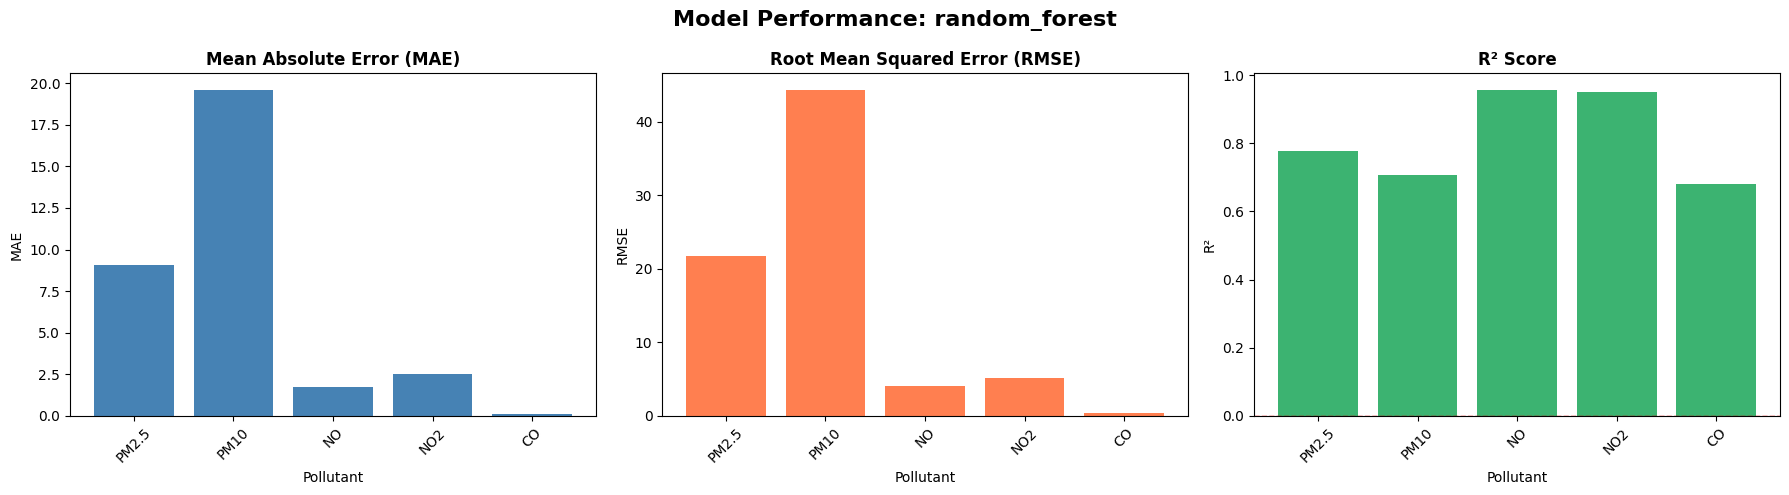

Plot saved to: results/random_forest_20260131_143926_metrics.png


In [ ]:
# ============================================================================
# ⚠️ DEPRECATED - NOT SUPPORTED
# Single-model visualization is deprecated.
# Use Section 10 or Section 12 for comprehensive visualizations.
# ============================================================================

print("=" * 80)
print("⚠️  This visualization cell is DEPRECATED")
print("=" * 80)
print("\nFor visualizations, use:")
print("  • Section 10: Comparison across all 6 models")
print("  • Section 12: Before/after comparison for fine-tuned models")
print("=" * 80)

# # OLD CODE - KEPT FOR REFERENCE ONLY
# # Plot performance metrics
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# fig.suptitle(f'Model Performance: {SELECTED_MODEL}', fontsize=16, fontweight='bold')
# 
# pollutants = [p for p in TARGET_POLLUTANTS]
# mae_values = [results['metrics'][p]['MAE'] for p in pollutants]
# rmse_values = [results['metrics'][p]['RMSE'] for p in pollutants]
# r2_values = [results['metrics'][p]['R2'] for p in pollutants]
# 
# # MAE plot
# axes[0].bar(pollutants, mae_values, color='steelblue')
# axes[0].set_title('Mean Absolute Error (MAE)', fontweight='bold')
# ...

## 11. Compare All Models (Optional)

Run this section to train and compare all available models.


Training: linear_regression
Description: Linear Regression - Simple baseline model
Training completed in 0.65 seconds

Performance Metrics:
--------------------------------------------------------------------------------
Pollutant  MAE          RMSE         R²           Train R²    
--------------------------------------------------------------------------------
PM2.5      15.6754      34.7524      0.4352       0.4819      
PM10       32.7533      62.5846      0.4153       0.4549      
NO         5.2082       8.3290       0.8221       0.8247      
NO2        11.2543      16.2852      0.5157       0.5137      
CO         0.2875       0.5593       0.2835       0.3275      
--------------------------------------------------------------------------------
AVERAGE    13.0357      24.5021      0.4944       0.5205      
--------------------------------------------------------------------------------

Training: ridge
Description: Ridge Regression - L2 regularization
Training completed in 0.15 

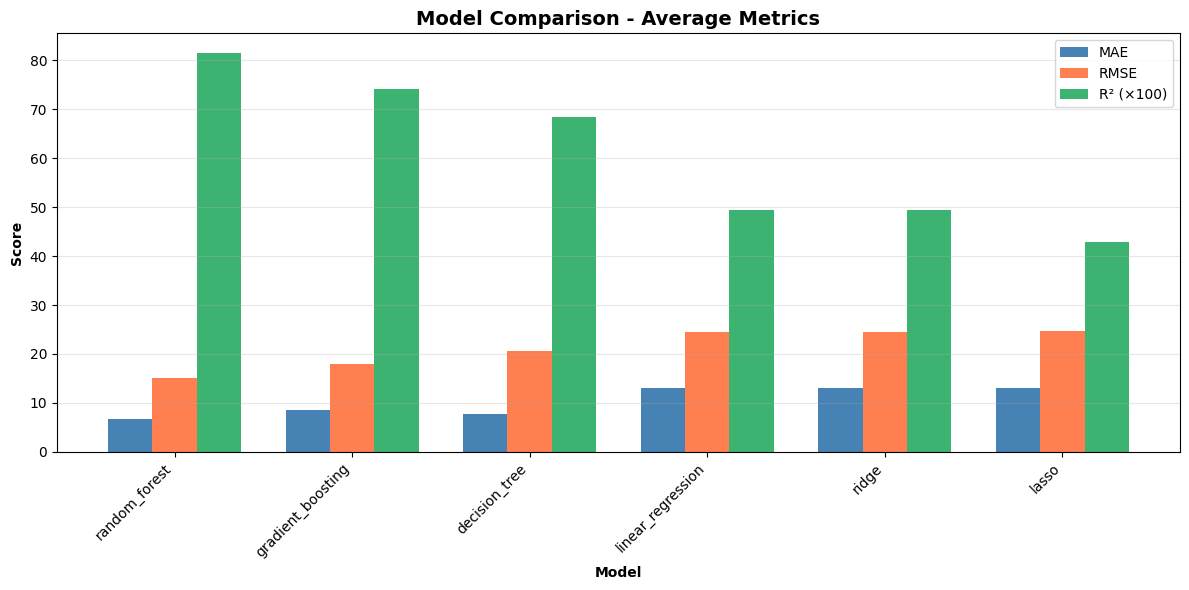

In [48]:
# Set to True to train all models
TRAIN_ALL_MODELS = True  # <-- Change to True to compare all models

if TRAIN_ALL_MODELS:
    all_results = {}
    
    for model_name, model_config in MODELS.items():
        result = train_model(
            model_name,
            model_config,
            X_train,
            X_train_scaled,
            X_test,
            X_test_scaled,
            y_train,
            y_test
        )
        all_results[model_name] = result
    
    # Create comparison DataFrame
    comparison_data = []
    for model_name, result in all_results.items():
        avg_metrics = result['metrics']['AVERAGE']
        comparison_data.append({
            'Model': model_name,
            'MAE': avg_metrics['MAE'],
            'RMSE': avg_metrics['RMSE'],
            'R²': avg_metrics['R2'],
            'Training Time (s)': result['training_time']
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    df_comparison = df_comparison.sort_values('R²', ascending=False)
    
    print("\nModel Comparison (sorted by R²):")
    print("=" * 80)
    print(df_comparison.to_string(index=False))
    
    # Save comparison to CSV
    comparison_path = os.path.join(RESULTS_DIR, f'model_comparison_{timestamp}.csv')
    df_comparison.to_csv(comparison_path, index=False)
    print(f"\nComparison saved to: {comparison_path}")
    
    # Visualize comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(df_comparison))
    width = 0.25
    
    ax.bar(x - width, df_comparison['MAE'], width, label='MAE', color='steelblue')
    ax.bar(x, df_comparison['RMSE'], width, label='RMSE', color='coral')
    ax.bar(x + width, df_comparison['R²'] * 100, width, label='R² (×100)', color='mediumseagreen')
    
    ax.set_xlabel('Model', fontweight='bold')
    ax.set_ylabel('Score', fontweight='bold')
    ax.set_title('Model Comparison - Average Metrics', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(df_comparison['Model'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, f'model_comparison_{timestamp}.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Set TRAIN_ALL_MODELS = True to compare all models")

In [55]:
# Save all the models if TRAIN_ALL_MODELS is True
if TRAIN_ALL_MODELS:
    # Create models directory if it doesn't exist
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
    
    timestamp_all = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save all models
    for model_name, result in all_results.items():
        model_filename = f"{model_name}_{timestamp_all}.pkl"
        model_path = os.path.join(MODEL_SAVE_DIR, model_filename)
        joblib.dump(result['model'], model_path)
        print(f"Model '{model_name}' saved to: {model_path}")
    
    # Save scalers for models that use scaling
    for model_name, result in all_results.items():
        if result['use_scaling']:
            scaler_filename = f"scaler_{model_name}_{timestamp_all}.pkl"
            scaler_path = os.path.join(MODEL_SAVE_DIR, scaler_filename)
            # Use the same scaler that was created during training
            joblib.dump(scaler, scaler_path)
            print(f"Scaler for '{model_name}' saved to: {scaler_path}")
    
    print(f"\n✓ All models and scalers saved successfully!")
else:
    print("Set TRAIN_ALL_MODELS = True to train and save all models")

Model 'linear_regression' saved to: models/linear_regression_20260131_145845.pkl
Model 'ridge' saved to: models/ridge_20260131_145845.pkl
Model 'lasso' saved to: models/lasso_20260131_145845.pkl
Model 'decision_tree' saved to: models/decision_tree_20260131_145845.pkl
Model 'random_forest' saved to: models/random_forest_20260131_145845.pkl
Model 'gradient_boosting' saved to: models/gradient_boosting_20260131_145845.pkl
Scaler for 'linear_regression' saved to: models/scaler_linear_regression_20260131_145845.pkl
Scaler for 'ridge' saved to: models/scaler_ridge_20260131_145845.pkl
Scaler for 'lasso' saved to: models/scaler_lasso_20260131_145845.pkl

✓ All models and scalers saved successfully!


## 12. Incremental Training (Fine-Tuning) - ONLY Warm-Start Supported Models

**What is Fine-Tuning?**
Fine-tuning means continuing to train an existing model on new data without starting from scratch. The model keeps its learned patterns and adjusts based on new data.

**🆕 UPDATED: Now intelligently handles model capabilities!**
The system automatically:
- ✓ **Loads ONLY models that support warm_start** (RandomForest, GradientBoosting)
- ✓ **Skips models that don't support warm_start** (Linear, Ridge, Lasso, DecisionTree)
- ✓ Keeps skipped models at their original paths (no knowledge loss)
- ✓ Only incrementally trains models that can truly learn incrementally

**How It Works:**
1. **Auto-filters models** based on `supports_warm_start` capability
2. Loads ONLY models that support incremental training (RandomForest, GradientBoosting)
3. Loads ONLY new data chunks (no need to keep old data)
4. Continues training with `warm_start=True`
5. Models ADD new estimators while KEEPING old ones

**Model Support:**
- ✓ **RandomForest**: Supports warm_start → Adds new trees (INCREMENTAL)
- ✓ **GradientBoosting**: Supports warm_start → Adds new stages (INCREMENTAL)
- ⊘ **Linear/Ridge/Lasso**: No warm_start → Skipped (keeps original)
- ⊘ **DecisionTree**: No warm_start → Skipped (keeps original)

**Why Skip Models Without Warm-Start?**
Models without warm_start would need to retrain from scratch on new data ONLY, causing them to:
- ❌ Forget all patterns learned from old data
- ❌ Lose predictive accuracy
- ❌ Become useless for real-world predictions

By skipping them, we:
- ✓ Keep their original versions (trained on full historical data)
- ✓ Maintain prediction quality
- ✓ Only update models that can truly learn incrementally

**Memory Efficient:** 
- Old data can be deleted after initial training
- Only need new data chunks for fine-tuning
- Perfect for continuous learning pipelines

**To Update Skipped Models:**
If you need to update Linear/Ridge/Lasso/DecisionTree models, use Section 10 "Train All Models" with combined old+new data (requires keeping historical data).

### 12.1 Configuration for Incremental Training

In [62]:
# ============================================================================
# FINE-TUNING CONFIGURATION
# ============================================================================

# Set to True to enable fine-tuning (incremental training)
ENABLE_INCREMENTAL_TRAINING = True  # <-- Change to True to enable

# Path to existing model file (leave empty to auto-select latest)
EXISTING_MODEL_PATH = ''  # Example: 'models/random_forest_20260131_123456.pkl'

# Path to existing scaler file (if model uses scaling)
EXISTING_SCALER_PATH = ''  # Example: 'models/scaler_20260131_123456.pkl'

# Directory containing NEW data chunks ONLY (old data NOT needed)
NEW_DATA_DIR = 'output2'  # Folder with NEW data chunks
# Or specify specific new chunk files
NEW_CHUNK_FILES = []  # Example: ['output2/DL039/DL039_chunk_1.csv']

# Percentage of new data files to use (1.0 = 100%, 0.5 = 50%)
NEW_DATA_PERCENTAGE = 1.0  # Use all available new data files

# For RandomForest/GradientBoosting: Number of additional estimators to add
N_ADDITIONAL_ESTIMATORS = 50  # Add 50 more trees/stages during fine-tuning

print(f"Fine-Tuning Configuration:")
print(f"  Enabled: {ENABLE_INCREMENTAL_TRAINING}")
print(f"  Existing model: {EXISTING_MODEL_PATH if EXISTING_MODEL_PATH else 'Auto-detect latest'}")
print(f"  New data directory: {NEW_DATA_DIR}")
print(f"  New data percentage: {NEW_DATA_PERCENTAGE*100}%")
print(f"  Additional estimators: {N_ADDITIONAL_ESTIMATORS}")

Fine-Tuning Configuration:
  Enabled: True
  Existing model: Auto-detect latest
  New data directory: output2
  New data percentage: 100.0%
  Additional estimators: 50


### 12.2 Load Existing Model and Scaler

In [73]:
if ENABLE_INCREMENTAL_TRAINING:
    print("Loading existing models for incremental training...")
    print("=" * 80)
    
    # Dictionary to store all loaded models and scalers
    loaded_models = {}
    loaded_scalers = {}
    skipped_models = {}  # Track models that don't support warm_start
    
    # Get all model files (excluding scalers)
    all_model_files = glob.glob(os.path.join(MODEL_SAVE_DIR, '*.pkl'))
    all_model_files = [f for f in all_model_files if 'scaler' not in f.lower()]
    
    if not all_model_files:
        raise FileNotFoundError(f"No model files found in {MODEL_SAVE_DIR}")
    
    # Group model files by model type
    model_groups = {}
    for model_file in all_model_files:
        filename = os.path.basename(model_file)
        # Extract model name (e.g., 'linear_regression' from 'linear_regression_20260131_145845.pkl')
        parts = filename.split('_')
        if 'boosting' in filename:
            model_type = 'gradient_boosting'
        elif 'forest' in filename:
            model_type = 'random_forest'
        elif 'tree' in filename:
            model_type = 'decision_tree'
        elif 'lasso' in filename:
            model_type = 'lasso'
        elif 'ridge' in filename:
            model_type = 'ridge'
        elif 'regression' in filename:
            model_type = 'linear_regression'
        else:
            continue
        
        if model_type not in model_groups:
            model_groups[model_type] = []
        model_groups[model_type].append(model_file)
    
    # Load the latest model for each model type (ONLY if it supports warm_start)
    for model_type, files in model_groups.items():
        # Get the latest file for this model type
        latest_model_file = max(files, key=os.path.getmtime)
        
        # Check if model supports warm_start
        supports_warm_start = MODELS.get(model_type, {}).get('supports_warm_start', False)
        
        # Debug: Print what we're checking
        print(f"\nChecking {model_type}:")
        print(f"  Found in MODELS dict: {model_type in MODELS}")
        if model_type in MODELS:
            print(f"  supports_warm_start value: {MODELS[model_type].get('supports_warm_start', 'KEY NOT FOUND')}")
        
        if not supports_warm_start:
            # Skip loading this model for incremental training
            skipped_models[model_type] = {
                'file': latest_model_file,
                'reason': 'Does not support warm_start - would lose old knowledge if retrained'
            }
            print(f"⊘ Skipped {model_type}: Does not support incremental training (warm_start)")
            continue
        
        try:
            # Load the model
            model = joblib.load(latest_model_file)
            loaded_models[model_type] = model
            print(f"✓ Loaded {model_type}: {os.path.basename(latest_model_file)}")
            
            # Try to load corresponding scaler if model uses scaling
            if model_type in ['linear_regression', 'ridge', 'lasso'] or \
               MODELS.get(model_type, {}).get('use_scaling', False):
                
                # Try to find matching scaler file
                timestamp = os.path.basename(latest_model_file).split('_')[-1].replace('.pkl', '')
                scaler_pattern = f"scaler_{model_type}_{timestamp}.pkl"
                scaler_path = os.path.join(MODEL_SAVE_DIR, scaler_pattern)
                
                if os.path.exists(scaler_path):
                    scaler = joblib.load(scaler_path)
                    loaded_scalers[model_type] = scaler
                    print(f"  ✓ Loaded scaler for {model_type}")
                else:
                    # Try to find any scaler for this model type
                    scaler_files = glob.glob(os.path.join(MODEL_SAVE_DIR, f'scaler_{model_type}_*.pkl'))
                    if scaler_files:
                        latest_scaler = max(scaler_files, key=os.path.getmtime)
                        scaler = joblib.load(latest_scaler)
                        loaded_scalers[model_type] = scaler
                        print(f"  ✓ Loaded scaler from: {os.path.basename(latest_scaler)}")
                    else:
                        loaded_scalers[model_type] = None
                        print(f"  ⚠️  No scaler found for {model_type}, will create new one")
            else:
                loaded_scalers[model_type] = None
        
        except Exception as e:
            print(f"✗ Failed to load {model_type}: {e}")
            continue
    
    print("\n" + "=" * 80)
    if loaded_models:
        print(f"✓ Successfully loaded {len(loaded_models)} model(s) for incremental training:")
        for model_type in loaded_models.keys():
            scaler_status = "with scaler" if loaded_scalers.get(model_type) is not None else "no scaler"
            print(f"  • {model_type} ({scaler_status})")
    
    if skipped_models:
        print(f"\n⊘ Skipped {len(skipped_models)} model(s) (will keep existing versions):")
        for model_type, info in skipped_models.items():
            print(f"  • {model_type} - {info['reason']}")
        print(f"\n  Note: Skipped models remain available at their original saved paths")
        print(f"        They can still be used for predictions, just not incrementally trained")
    
    print("=" * 80)
    print("✓ Model loading complete!\n")
    
else:
    print("Incremental training is disabled. Set ENABLE_INCREMENTAL_TRAINING = True to enable.")

Loading existing models for incremental training...

Checking gradient_boosting:
  Found in MODELS dict: True
  supports_warm_start value: True
✓ Loaded gradient_boosting: gradient_boosting_20260131_145845.pkl

Checking lasso:
  Found in MODELS dict: True
  supports_warm_start value: False
⊘ Skipped lasso: Does not support incremental training (warm_start)

Checking decision_tree:
  Found in MODELS dict: True
  supports_warm_start value: False
⊘ Skipped decision_tree: Does not support incremental training (warm_start)

Checking linear_regression:
  Found in MODELS dict: True
  supports_warm_start value: False
⊘ Skipped linear_regression: Does not support incremental training (warm_start)

Checking ridge:
  Found in MODELS dict: True
  supports_warm_start value: False
⊘ Skipped ridge: Does not support incremental training (warm_start)

Checking random_forest:
  Found in MODELS dict: True
  supports_warm_start value: True
✓ Loaded random_forest: random_forest_20260131_145845.pkl

✓ Succe

### 12.3 Load New Data for Incremental Training

In [74]:
if ENABLE_INCREMENTAL_TRAINING:
    print("Loading new data chunks for incremental training...")
    print("=" * 80)
    
    # Determine which files to load
    if NEW_CHUNK_FILES:
        # Use explicitly specified files
        new_chunks = NEW_CHUNK_FILES
        print(f"Using {len(new_chunks)} explicitly specified chunk files")
    else:
        # Load all chunks from NEW_DATA_DIR
        new_chunks = glob.glob(os.path.join(NEW_DATA_DIR, '*', '*.csv'))
        print(f"Found {len(new_chunks)} chunk files in {NEW_DATA_DIR}")
    
    if not new_chunks:
        raise FileNotFoundError(f"No data chunks found. Check NEW_DATA_DIR or NEW_CHUNK_FILES.")
    
    # Optionally limit to a percentage of files
    if NEW_DATA_PERCENTAGE < 1.0:
        import random
        num_files = int(len(new_chunks) * NEW_DATA_PERCENTAGE)
        new_chunks = random.sample(new_chunks, num_files)
        print(f"Randomly selected {num_files} files ({NEW_DATA_PERCENTAGE*100}% of total)")
    
    print(f"\nSample files:")
    for i, file in enumerate(new_chunks[:5]):
        print(f"  {i+1}. {file}")
    if len(new_chunks) > 5:
        print(f"  ... and {len(new_chunks) - 5} more files")
    
    # Load and combine new chunks
    print(f"\nLoading new data chunks...")
    df_new_chunks_list = []
    
    for i, chunk_file in enumerate(new_chunks):
        try:
            df_chunk = pd.read_csv(chunk_file)
            df_new_chunks_list.append(df_chunk)
            
            if (i + 1) % 10 == 0:
                print(f"  Loaded {i + 1}/{len(new_chunks)} files...")
        except Exception as e:
            print(f"  Error loading {chunk_file}: {e}")
    
    # Combine all new chunks
    df_new_aq = pd.concat(df_new_chunks_list, ignore_index=True)
    
    print(f"\nNew data loaded:")
    print(f"  Total rows: {len(df_new_aq):,}")
    print(f"  Total columns: {len(df_new_aq.columns)}")
    print(f"  Memory usage: {df_new_aq.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print("=" * 80)
    print("✓ New data loading complete!\n")
    
else:
    print("Incremental training is disabled.")

Loading new data chunks for incremental training...
Found 22 chunk files in output2

Sample files:
  1. output2/MH005/MH005_chunk_5.csv
  2. output2/MH005/MH005_chunk_4.csv
  3. output2/MH005/MH005_chunk_1.csv
  4. output2/MH005/MH005_chunk_3.csv
  5. output2/MH005/MH005_chunk_2.csv
  ... and 17 more files

Loading new data chunks...
  Loaded 10/22 files...
  Loaded 20/22 files...

New data loaded:
  Total rows: 185,962
  Total columns: 42
  Memory usage: 325.25 MB
✓ New data loading complete!



### 12.4 Preprocess New Data (Same as Original Pipeline)

In [75]:
if ENABLE_INCREMENTAL_TRAINING:
    print("Preprocessing new data...")
    print("=" * 80)
    
    # 1. Parse datetime and create temporal features (same as before)
    datetime_col_new = None
    for col in df_new_aq.columns:
        if col.lower() in ['datetime', 'date', 'timestamp', 'time']:
            datetime_col_new = col
            break
    
    if datetime_col_new:
        df_new_aq[datetime_col_new] = pd.to_datetime(df_new_aq[datetime_col_new])
        df_new_aq['year'] = df_new_aq[datetime_col_new].dt.year
        df_new_aq['month'] = df_new_aq[datetime_col_new].dt.month
        df_new_aq['day'] = df_new_aq[datetime_col_new].dt.day
        df_new_aq['hour'] = df_new_aq[datetime_col_new].dt.hour
        df_new_aq['day_of_week'] = df_new_aq[datetime_col_new].dt.dayofweek
        df_new_aq['day_of_year'] = df_new_aq[datetime_col_new].dt.dayofyear
        df_new_aq['week_of_year'] = df_new_aq[datetime_col_new].dt.isocalendar().week
        df_new_aq['is_weekend'] = (df_new_aq['day_of_week'] >= 5).astype(int)
        df_new_aq['hour_sin'] = np.sin(2 * np.pi * df_new_aq['hour'] / 24)
        df_new_aq['hour_cos'] = np.cos(2 * np.pi * df_new_aq['hour'] / 24)
        df_new_aq['month_sin'] = np.sin(2 * np.pi * df_new_aq['month'] / 12)
        df_new_aq['month_cos'] = np.cos(2 * np.pi * df_new_aq['month'] / 12)
        print("✓ Temporal features created")
    
    # 2. Merge with OSM features
    station_id_col_new = None
    for col in df_new_aq.columns:
        if 'station' in col.lower() and 'id' in col.lower():
            station_id_col_new = col
            break
    if not station_id_col_new:
        for col in df_new_aq.columns:
            if col.lower() in ['stationid', 'station_id', 'station']:
                station_id_col_new = col
                break
    
    df_new_merged = df_new_aq.merge(
        df_osm,
        left_on=station_id_col_new,
        right_on='station_id',
        how='inner'
    )
    print(f"✓ Merged with OSM features: {len(df_new_merged):,} rows")
    
    # 3. Create feature matrix - select same columns as original training
    # Use the feature_cols list but handle missing columns gracefully
    available_feature_cols = [col for col in feature_cols if col in df_new_merged.columns]
    missing_feature_cols = [col for col in feature_cols if col not in df_new_merged.columns]
    
    if missing_feature_cols:
        print(f"⚠️  Warning: {len(missing_feature_cols)} feature columns missing in new data")
        print(f"    First few missing: {missing_feature_cols[:5]}")
    
    X_new = df_new_merged[available_feature_cols].copy()
    y_new = df_new_merged[TARGET_POLLUTANTS].copy()
    
    print(f"✓ Feature matrix (before processing): {X_new.shape}")
    print(f"✓ Target matrix: {y_new.shape}")
    
    # 4. Handle categorical features (SAME EXACT LOGIC as original)
    categorical_cols_new = X_new.select_dtypes(include=['object']).columns.tolist()
    if categorical_cols_new:
        print(f"\nProcessing {len(categorical_cols_new)} categorical features...")
        for col in categorical_cols_new:
            X_new[f'{col}_count'] = X_new[col].fillna('').apply(lambda x: len(str(x).split(',')) if x else 0)
            X_new = X_new.drop(columns=[col])
        print(f"✓ Features after categorical processing: {len(X_new.columns)}")
    
    # 5. Ensure only numeric columns
    X_new_numeric = X_new.select_dtypes(include=[np.number]).copy()
    
    # 6. Align columns with training data (X_imputed columns)
    # Get the columns from the original training data
    training_columns = X_imputed.columns.tolist()
    
    # Add missing columns with zeros
    for col in training_columns:
        if col not in X_new_numeric.columns:
            X_new_numeric[col] = 0
            print(f"  Added missing column '{col}' with zeros")
    
    # Remove extra columns not in training data
    extra_cols = [col for col in X_new_numeric.columns if col not in training_columns]
    if extra_cols:
        print(f"  Removing {len(extra_cols)} extra columns not in training data")
        X_new_numeric = X_new_numeric.drop(columns=extra_cols)
    
    # Reorder columns to match training data
    X_new_numeric = X_new_numeric[training_columns]
    
    print(f"\n✓ Aligned features with training data: {X_new_numeric.shape}")
    print(f"  Column match: {list(X_new_numeric.columns) == training_columns}")
    
    # 7. Impute missing values in features
    imputer_new = SimpleImputer(strategy='median')
    X_new_imputed_array = imputer_new.fit_transform(X_new_numeric)
    X_new_imputed = pd.DataFrame(
        X_new_imputed_array,
        columns=training_columns,  # Use training columns explicitly
        index=X_new_numeric.index
    )
    print(f"✓ Imputed features: {X_new_imputed.shape}")
    
    # 8. Handle missing values in targets (using impute strategy)
    y_new_clean = y_new.copy()
    for col in TARGET_POLLUTANTS:
        if y_new_clean[col].isnull().any():
            median_val = y_new_clean[col].median()
            if pd.isna(median_val):
                median_val = y[col].median()  # Use original data median
            y_new_clean[col] = y_new_clean[col].fillna(median_val)
    
    print(f"✓ Cleaned targets: {y_new_clean.isnull().sum().sum()} NaN values")
    
    print("=" * 80)
    print("✓ New data preprocessing complete!\n")
    
else:
    print("Incremental training is disabled.")

Preprocessing new data...
✓ Temporal features created
✓ Merged with OSM features: 243,383 rows
✓ Feature matrix (before processing): (243383, 73)
✓ Target matrix: (243383, 5)

Processing 53 categorical features...
✓ Features after categorical processing: 73
  Added missing column 'craft_x' with zeros
  Added missing column 'emergency_x' with zeros
  Added missing column 'industrial_x' with zeros
  Added missing column 'military_x' with zeros
  Removing 8 extra columns not in training data

✓ Aligned features with training data: (243383, 69)
  Column match: True
✓ Imputed features: (243383, 69)
✓ Cleaned targets: 0 NaN values
✓ New data preprocessing complete!



### 12.5 Prepare Model for Fine-Tuning

In [76]:
if ENABLE_INCREMENTAL_TRAINING:
    print("Preparing models for fine-tuning on NEW data...")
    print("=" * 80)
    
    if not loaded_models:
        print("⚠️  No models loaded for incremental training!")
        print("   This means no models support warm_start, or no models were found.")
        print("   Please train models using Section 10 first.")
        print("=" * 80)
    else:
        # Training data = NEW data ONLY (no historical data needed!)
        X_for_training = X_new_imputed
        y_for_training = y_new_clean
        
        print(f"Training data: {X_for_training.shape[0]:,} rows (NEW data only)")
        print("✓ Old data NOT required - can be deleted to save space\n")
        
        # Configure each loaded model for fine-tuning
        print(f"Configuring {len(loaded_models)} model(s) for fine-tuning...\n")
        
        for model_name, model in loaded_models.items():
            print(f"[{model_name}]")
            
            # All loaded models should support warm_start (we filtered during loading)
            supports_warm_start = MODELS.get(model_name, {}).get('supports_warm_start', False)
            
            # Check if model uses MultiOutputRegressor wrapper
            if hasattr(model, 'estimators_'):  # MultiOutputRegressor
                base_estimator = model.estimators_[0]
                
                if isinstance(base_estimator, RandomForestRegressor):
                    current_n = base_estimator.n_estimators
                    print(f"  Current n_estimators: {current_n}")
                    
                    # Enable warm_start and increase n_estimators
                    for estimator in model.estimators_:
                        estimator.warm_start = True
                        estimator.n_estimators = current_n + N_ADDITIONAL_ESTIMATORS
                    
                    print(f"  ✓ Enabled warm_start=True")
                    print(f"  ✓ New n_estimators: {current_n + N_ADDITIONAL_ESTIMATORS} (+{N_ADDITIONAL_ESTIMATORS} trees)")
                    print(f"  → Will ADD {N_ADDITIONAL_ESTIMATORS} new trees trained on new data")
                    print(f"  → Keeps existing {current_n} trees (true incremental learning)\n")
                    
                elif isinstance(base_estimator, GradientBoostingRegressor):
                    current_n = base_estimator.n_estimators
                    print(f"  Current n_estimators: {current_n}")
                    
                    # Enable warm_start and increase n_estimators
                    for estimator in model.estimators_:
                        estimator.warm_start = True
                        estimator.n_estimators = current_n + N_ADDITIONAL_ESTIMATORS
                    
                    print(f"  ✓ Enabled warm_start=True")
                    print(f"  ✓ New n_estimators: {current_n + N_ADDITIONAL_ESTIMATORS} (+{N_ADDITIONAL_ESTIMATORS} stages)")
                    print(f"  → Will ADD {N_ADDITIONAL_ESTIMATORS} new boosting stages")
                    print(f"  → Keeps existing {current_n} stages (true incremental learning)\n")
                    
                else:
                    print(f"  Model type: {type(base_estimator).__name__}")
                    if supports_warm_start:
                        print(f"  ✓ Supports warm_start - will perform incremental training")
                    print()
            else:
                print(f"  Single-output model: {type(model).__name__}")
                if supports_warm_start:
                    print(f"  ✓ Supports warm_start - will perform incremental training")
                print()
        
        # Ensure no NaN values
        nan_count_X = X_for_training.isnull().sum().sum()
        nan_count_y = y_for_training.isnull().sum().sum()
        
        if nan_count_X > 0 or nan_count_y > 0:
            print(f"⚠️  Found {nan_count_X} NaN in features, {nan_count_y} NaN in targets")
            print("Applying final cleanup...")
            
            for col in X_for_training.columns:
                if X_for_training[col].isnull().any():
                    X_for_training[col] = X_for_training[col].fillna(X_for_training[col].median())
            
            for col in y_for_training.columns:
                if y_for_training[col].isnull().any():
                    y_for_training[col] = y_for_training[col].fillna(y_for_training[col].median())
        
        print(f"\nFinal training dataset:")
        print(f"  X shape: {X_for_training.shape}")
        print(f"  y shape: {y_for_training.shape}")
        print(f"  NaN in X: {X_for_training.isnull().sum().sum()}")
        print(f"  NaN in y: {y_for_training.isnull().sum().sum()}")
        
        # Prepare scaled/unscaled data for each model
        model_training_data = {}
        
        for model_name in loaded_models.keys():
            uses_scaling = MODELS.get(model_name, {}).get('use_scaling', False)
            
            if uses_scaling:
                scaler = loaded_scalers.get(model_name)
                if scaler is not None:
                    print(f"\n[{model_name}] Using existing scaler (NOT refitting)")
                    X_scaled = scaler.transform(X_for_training)
                else:
                    print(f"\n[{model_name}] Creating new scaler")
                    scaler = StandardScaler()
                    X_scaled = scaler.fit_transform(X_for_training)
                    loaded_scalers[model_name] = scaler
                
                X_final = pd.DataFrame(
                    X_scaled,
                    columns=X_for_training.columns,
                    index=X_for_training.index
                )
            else:
                X_final = X_for_training
            
            model_training_data[model_name] = X_final
        
        print("=" * 80)
        print("✓ All models prepared for fine-tuning!")
        print("\nIncremental Training Summary:")
        print(f"  • Models to be incrementally trained: {len(loaded_models)}")
        for model_name in loaded_models.keys():
            print(f"    - {model_name}")
        if 'skipped_models' in locals() and skipped_models:
            print(f"  • Models kept as-is (no warm_start support): {len(skipped_models)}")
            for model_name in skipped_models.keys():
                print(f"    - {model_name} (will keep original version)")
        print("=" * 80)
        print()
    
else:
    print("Incremental training is disabled.")

Preparing models for fine-tuning on NEW data...
Training data: 243,383 rows (NEW data only)
✓ Old data NOT required - can be deleted to save space

Configuring 2 model(s) for fine-tuning...

[gradient_boosting]
  Current n_estimators: 100
  ✓ Enabled warm_start=True
  ✓ New n_estimators: 150 (+50 stages)
  → Will ADD 50 new boosting stages
  → Keeps existing 100 stages (true incremental learning)

[random_forest]
  Current n_estimators: 100
  ✓ Enabled warm_start=True
  ✓ New n_estimators: 150 (+50 trees)
  → Will ADD 50 new trees trained on new data
  → Keeps existing 100 trees (true incremental learning)


Final training dataset:
  X shape: (243383, 69)
  y shape: (243383, 5)
  NaN in X: 0
  NaN in y: 0
✓ All models prepared for fine-tuning!

Incremental Training Summary:
  • Models to be incrementally trained: 2
    - gradient_boosting
    - random_forest
  • Models kept as-is (no warm_start support): 4
    - lasso (will keep original version)
    - decision_tree (will keep original

### 12.6 Evaluate Model Performance BEFORE Retraining

In [77]:
if ENABLE_INCREMENTAL_TRAINING:
    print("Evaluating ALL existing models performance on test set (BEFORE retraining)...")
    print("=" * 80)
    
    # Store metrics for all models BEFORE retraining
    all_metrics_before = {}
    
    for model_name, model in loaded_models.items():
        print(f"\n[{model_name.upper()}]")
        print("-" * 80)
        
        # Get appropriate test data (scaled or unscaled)
        uses_scaling = model_name in ['linear_regression', 'ridge', 'lasso'] or \
                      MODELS.get(model_name, {}).get('use_scaling', False)
        
        X_test_for_eval = X_test_scaled if uses_scaling else X_test
        
        try:
            # Make predictions with existing model
            y_test_pred_before = model.predict(X_test_for_eval)
            
            # Calculate metrics
            print(f"{'Pollutant':<10} {'MAE':<12} {'RMSE':<12} {'R²':<12}")
            print("-" * 80)
            
            metrics_before = {}
            for i, pollutant in enumerate(TARGET_POLLUTANTS):
                mae = mean_absolute_error(y_test.iloc[:, i], y_test_pred_before[:, i])
                rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_test_pred_before[:, i]))
                r2 = r2_score(y_test.iloc[:, i], y_test_pred_before[:, i])
                
                metrics_before[pollutant] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
                print(f"{pollutant:<10} {mae:<12.4f} {rmse:<12.4f} {r2:<12.4f}")
            
            # Average metrics
            avg_mae_before = np.mean([m['MAE'] for m in metrics_before.values()])
            avg_rmse_before = np.mean([m['RMSE'] for m in metrics_before.values()])
            avg_r2_before = np.mean([m['R2'] for m in metrics_before.values()])
            
            print("-" * 80)
            print(f"{'AVERAGE':<10} {avg_mae_before:<12.4f} {avg_rmse_before:<12.4f} {avg_r2_before:<12.4f}")
            
            metrics_before['AVERAGE'] = {'MAE': avg_mae_before, 'RMSE': avg_rmse_before, 'R2': avg_r2_before}
            all_metrics_before[model_name] = metrics_before
            
        except Exception as e:
            print(f"✗ Error evaluating {model_name}: {e}")
            all_metrics_before[model_name] = None
    
    print("\n" + "=" * 80)
    print("✓ Baseline evaluation complete for all models!\n")
    
else:
    print("Incremental training is disabled.")

Evaluating ALL existing models performance on test set (BEFORE retraining)...

[GRADIENT_BOOSTING]
--------------------------------------------------------------------------------
Pollutant  MAE          RMSE         R²          
--------------------------------------------------------------------------------
PM2.5      11.9563      26.2101      0.6787      
PM10       24.4968      50.9236      0.6129      
NO         2.2707       4.6562       0.9444      
NO2        3.7595       7.0476       0.9093      
CO         0.1980       0.4354       0.5657      
--------------------------------------------------------------------------------
AVERAGE    8.5363       17.8546      0.7422      

[RANDOM_FOREST]
--------------------------------------------------------------------------------
Pollutant  MAE          RMSE         R²          
--------------------------------------------------------------------------------
PM2.5      9.0851       21.7564      0.7786      
PM10       19.6119      44.36

### 12.7 Fine-Tune Model on New Data

In [ ]:
if ENABLE_INCREMENTAL_TRAINING:
    print("Fine-tuning ALL models on new data...")
    print("=" * 80)
    
    # Store fine-tuning times for all models
    finetuning_times = {}
    
    for model_name, model in loaded_models.items():
        print(f"\n[{model_name.upper()}]")
        print("-" * 80)
        
        # Get appropriate training data (scaled or unscaled)
        X_train_data = model_training_data[model_name]
        uses_scaling = model_name in ['linear_regression', 'ridge', 'lasso'] or \
                      MODELS.get(model_name, {}).get('use_scaling', False)
        
        print(f"Model type: {model_name}")
        print(f"Uses scaling: {uses_scaling}")
        print(f"Training data shape: {X_train_data.shape}")
        print(f"Target data shape: {y_for_training.shape}")
        
        # Fine-tune the model on NEW data
        print(f"\nFine-tuning on {X_train_data.shape[0]:,} new samples...")
        start_time = datetime.now()
        
        try:
            # Train with .fit() - warm_start ensures it continues from existing weights
            model.fit(X_train_data, y_for_training)
            
            finetuning_time = (datetime.now() - start_time).total_seconds()
            finetuning_times[model_name] = finetuning_time
            
            print(f"✓ Fine-tuning completed in {finetuning_time:.2f} seconds")
            
        except Exception as e:
            print(f"✗ Error fine-tuning {model_name}: {e}")
            finetuning_times[model_name] = None
    
    print("\n" + "=" * 80)
    print("✓ Fine-tuning complete for all models!")
    print("\nFine-tuning Summary:")
    print("-" * 80)
    for model_name, time_taken in finetuning_times.items():
        if time_taken:
            print(f"  {model_name:<20}: {time_taken:>8.2f} seconds")
        else:
            print(f"  {model_name:<20}: Failed")
    print("=" * 80)
    
else:
    print("Incremental training is disabled.")

Fine-tuning ALL models on new data...

[GRADIENT_BOOSTING]
--------------------------------------------------------------------------------
Model type: gradient_boosting
Uses scaling: False
Training data shape: (243383, 69)
Target data shape: (243383, 5)

Fine-tuning on 243,383 new samples...


### 12.8 Compare Performance: Before vs After Fine-Tuning

In [ ]:
if ENABLE_INCREMENTAL_TRAINING:
    print("Evaluating ALL fine-tuned models on test set (AFTER retraining)...")
    print("=" * 80)
    
    # Store metrics for all models AFTER retraining
    all_metrics_after = {}
    
    for model_name, model in loaded_models.items():
        print(f"\n[{model_name.upper()}]")
        print("-" * 80)
        
        # Get appropriate test data (scaled or unscaled)
        uses_scaling = model_name in ['linear_regression', 'ridge', 'lasso'] or \
                      MODELS.get(model_name, {}).get('use_scaling', False)
        
        X_test_for_eval = X_test_scaled if uses_scaling else X_test
        
        try:
            # Make predictions with fine-tuned model
            y_test_pred_after = model.predict(X_test_for_eval)
            
            # Calculate metrics
            print(f"{'Pollutant':<10} {'MAE':<12} {'RMSE':<12} {'R²':<12}")
            print("-" * 80)
            
            metrics_after = {}
            for i, pollutant in enumerate(TARGET_POLLUTANTS):
                mae = mean_absolute_error(y_test.iloc[:, i], y_test_pred_after[:, i])
                rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_test_pred_after[:, i]))
                r2 = r2_score(y_test.iloc[:, i], y_test_pred_after[:, i])
                
                metrics_after[pollutant] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
                print(f"{pollutant:<10} {mae:<12.4f} {rmse:<12.4f} {r2:<12.4f}")
            
            # Average metrics
            avg_mae_after = np.mean([m['MAE'] for m in metrics_after.values()])
            avg_rmse_after = np.mean([m['RMSE'] for m in metrics_after.values()])
            avg_r2_after = np.mean([m['R2'] for m in metrics_after.values()])
            
            print("-" * 80)
            print(f"{'AVERAGE':<10} {avg_mae_after:<12.4f} {avg_rmse_after:<12.4f} {avg_r2_after:<12.4f}")
            
            metrics_after['AVERAGE'] = {'MAE': avg_mae_after, 'RMSE': avg_rmse_after, 'R2': avg_r2_after}
            all_metrics_after[model_name] = metrics_after
            
        except Exception as e:
            print(f"✗ Error evaluating {model_name}: {e}")
            all_metrics_after[model_name] = None
    
    print("\n" + "=" * 80)
    print("✓ Post-training evaluation complete for all models!\n")
    
    # Now create comparison for each model
    print("\n" + "=" * 80)
    print("PERFORMANCE COMPARISON: BEFORE vs AFTER Fine-Tuning")
    print("=" * 80)
    
    for model_name in loaded_models.keys():
        if all_metrics_before.get(model_name) and all_metrics_after.get(model_name):
            print(f"\n[{model_name.upper()}]")
            print("-" * 80)
            
            metrics_before = all_metrics_before[model_name]
            metrics_after = all_metrics_after[model_name]
            
            # Create comparison table
            print(f"{'Pollutant':<10} {'MAE_Before':<12} {'MAE_After':<12} {'Change':<12} {'Change_%':<12}")
            print("-" * 80)
            
            for pollutant in TARGET_POLLUTANTS + ['AVERAGE']:
                before = metrics_before[pollutant]
                after = metrics_after[pollutant]
                
                mae_change = after['MAE'] - before['MAE']
                mae_change_pct = ((after['MAE'] - before['MAE']) / before['MAE']) * 100 if before['MAE'] != 0 else 0
                
                # Use ↓ for improvement (lower MAE), ↑ for degradation
                change_symbol = "↓" if mae_change < 0 else "↑" if mae_change > 0 else "="
                
                print(f"{pollutant:<10} {before['MAE']:<12.4f} {after['MAE']:<12.4f} {mae_change:<11.4f}{change_symbol} {mae_change_pct:<11.2f}%")
            
            # Summary
            avg_before = metrics_before['AVERAGE']
            avg_after = metrics_after['AVERAGE']
            print("\n" + "-" * 80)
            print("Summary:")
            
            if avg_after['MAE'] < avg_before['MAE']:
                improvement = ((avg_before['MAE'] - avg_after['MAE']) / avg_before['MAE']) * 100
                print(f"  ✓ Model IMPROVED by {improvement:.2f}% (MAE decreased)")
            elif avg_after['MAE'] > avg_before['MAE']:
                degradation = ((avg_after['MAE'] - avg_before['MAE']) / avg_before['MAE']) * 100
                print(f"  ⚠️  Model DEGRADED by {degradation:.2f}% (MAE increased)")
            else:
                print(f"  = Model performance UNCHANGED")
    
    print("\n" + "=" * 80)
    print("✓ Comparison complete for all models!\n")
    
else:
    print("Incremental training is disabled.")

### 12.9 Save Fine-Tuned Model

In [ ]:
if ENABLE_INCREMENTAL_TRAINING:
    if not loaded_models:
        print("=" * 80)
        print("⚠️  No models were incrementally trained")
        print("=" * 80)
        print("\nReason: No models support warm_start for incremental learning.")
        print("All existing models are kept as-is at their original paths.")
        print("=" * 80)
    else:
        print("Saving ALL fine-tuned models...")
        print("=" * 80)
        
        # Create timestamp for versioning
        retrain_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        
        # Save all fine-tuned models
        for model_name, model in loaded_models.items():
            print(f"\n[{model_name}]")
            
            # Generate filenames
            finetuned_model_filename = f"{model_name}_finetuned_{retrain_timestamp}.pkl"
            finetuned_model_path = os.path.join(MODEL_SAVE_DIR, finetuned_model_filename)
            
            # Save model
            joblib.dump(model, finetuned_model_path)
            print(f"  ✓ Model saved to: {finetuned_model_filename}")
            
            # Save scaler if used
            if loaded_scalers.get(model_name) is not None:
                finetuned_scaler_filename = f"scaler_{model_name}_finetuned_{retrain_timestamp}.pkl"
                finetuned_scaler_path = os.path.join(MODEL_SAVE_DIR, finetuned_scaler_filename)
                joblib.dump(loaded_scalers[model_name], finetuned_scaler_path)
                print(f"  ✓ Scaler saved to: {finetuned_scaler_filename}")
            
            # Save metadata with comparison
            finetune_metadata_filename = f"metadata_{model_name}_finetuned_{retrain_timestamp}.txt"
            finetune_metadata_path = os.path.join(MODEL_SAVE_DIR, finetune_metadata_filename)
            
            with open(finetune_metadata_path, 'w') as f:
                f.write(f"FINE-TUNED MODEL METADATA\n")
                f.write("=" * 80 + "\n\n")
                
                f.write(f"Model: {model_name}\n")
                f.write(f"Fine-tuning Timestamp: {retrain_timestamp}\n")
                f.write(f"Fine-tuning Time: {finetuning_times.get(model_name, 'N/A'):.2f} seconds\n")
                f.write(f"Supports warm_start: True\n\n")
                
                f.write(f"FINE-TUNING SUMMARY:\n")
                f.write(f"  Training approach: True incremental learning (warm_start)\n")
                f.write(f"  New data samples: {X_for_training.shape[0]:,}\n")
                f.write(f"  Old data required: NO (memory efficient)\n")
                f.write(f"  Old knowledge retained: YES (incremental learning)\n")
                f.write(f"  Features: {X_for_training.shape[1]}\n")
                f.write(f"  Target pollutants: {', '.join(TARGET_POLLUTANTS)}\n\n")
                
                # Model-specific info
                if hasattr(model, 'estimators_'):
                    base_est = model.estimators_[0]
                    if isinstance(base_est, (RandomForestRegressor, GradientBoostingRegressor)):
                        f.write(f"  Model type: {type(base_est).__name__}\n")
                        f.write(f"  warm_start: {base_est.warm_start}\n")
                        f.write(f"  n_estimators: {base_est.n_estimators}\n\n")
                
                # Performance comparison
                if all_metrics_before.get(model_name) and all_metrics_after.get(model_name):
                    f.write(f"PERFORMANCE COMPARISON (on test set):\n")
                    f.write("=" * 80 + "\n\n")
                    
                    metrics_before = all_metrics_before[model_name]
                    metrics_after = all_metrics_after[model_name]
                    
                    f.write(f"{'Pollutant':<10} {'MAE_Before':<12} {'MAE_After':<12} {'Change':<12} {'Change_%':<12}\n")
                    f.write("-" * 80 + "\n")
                    
                    for pollutant in TARGET_POLLUTANTS + ['AVERAGE']:
                        before = metrics_before[pollutant]
                        after = metrics_after[pollutant]
                        
                        mae_change = after['MAE'] - before['MAE']
                        mae_change_pct = ((after['MAE'] - before['MAE']) / before['MAE']) * 100 if before['MAE'] != 0 else 0
                        
                        f.write(f"{pollutant:<10} {before['MAE']:<12.4f} {after['MAE']:<12.4f} {mae_change:<12.4f} {mae_change_pct:<12.2f}%\n")
                    
                    # Summary
                    avg_before = metrics_before['AVERAGE']
                    avg_after = metrics_after['AVERAGE']
                    f.write("\n" + "-" * 80 + "\n")
                    f.write("Summary:\n")
                    
                    if avg_after['MAE'] < avg_before['MAE']:
                        improvement = ((avg_before['MAE'] - avg_after['MAE']) / avg_before['MAE']) * 100
                        f.write(f"  Model IMPROVED by {improvement:.2f}% (MAE decreased)\n")
                    elif avg_after['MAE'] > avg_before['MAE']:
                        degradation = ((avg_after['MAE'] - avg_before['MAE']) / avg_before['MAE']) * 100
                        f.write(f"  Model DEGRADED by {degradation:.2f}% (MAE increased)\n")
                    else:
                        f.write(f"  Model performance UNCHANGED\n")
            
            print(f"  ✓ Metadata saved to: {finetune_metadata_filename}")
        
        print("\n" + "=" * 80)
        print(f"✓ All {len(loaded_models)} fine-tuned model(s) saved successfully!")
        print("\nSaved files (incrementally trained):")
        for model_name in loaded_models.keys():
            print(f"  • {model_name}_finetuned_{retrain_timestamp}.pkl")
            if loaded_scalers.get(model_name):
                print(f"  • scaler_{model_name}_finetuned_{retrain_timestamp}.pkl")
            print(f"  • metadata_{model_name}_finetuned_{retrain_timestamp}.txt")
        
        # Show info about skipped models
        if 'skipped_models' in locals() and skipped_models:
            print(f"\n⊘ Models kept as-is (not incrementally trained):")
            for model_name in skipped_models.keys():
                print(f"  • {model_name} - Original version remains available")
            print(f"\n  Note: These models don't support warm_start.")
            print(f"        To update them, retrain using Section 10 with combined old+new data.")
        
        print("=" * 80)
    
else:
    print("Incremental training is disabled.")

### 12.10 Visualize Before vs After Fine-Tuning Performance

In [ ]:
if ENABLE_INCREMENTAL_TRAINING:
    print("Creating fine-tuning performance comparison visualizations...")
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Fine-Tuning Results: {RETRAIN_MODEL_NAME}', fontsize=16, fontweight='bold')
    
    pollutants = [p for p in TARGET_POLLUTANTS]
    
    # 1. MAE Comparison
    mae_before = [metrics_before[p]['MAE'] for p in pollutants]
    mae_after = [metrics_after[p]['MAE'] for p in pollutants]
    
    x = np.arange(len(pollutants))
    width = 0.35
    
    axes[0, 0].bar(x - width/2, mae_before, width, label='Before Fine-tuning', color='coral', alpha=0.8)
    axes[0, 0].bar(x + width/2, mae_after, width, label='After Fine-tuning', color='steelblue', alpha=0.8)
    axes[0, 0].set_title('Mean Absolute Error (MAE) - Lower is Better', fontweight='bold')
    axes[0, 0].set_xlabel('Pollutant')
    axes[0, 0].set_ylabel('MAE')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(pollutants, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # 2. R² Comparison
    r2_before = [metrics_before[p]['R2'] for p in pollutants]
    r2_after = [metrics_after[p]['R2'] for p in pollutants]
    
    axes[0, 1].bar(x - width/2, r2_before, width, label='Before Fine-tuning', color='coral', alpha=0.8)
    axes[0, 1].bar(x + width/2, r2_after, width, label='After Fine-tuning', color='mediumseagreen', alpha=0.8)
    axes[0, 1].set_title('R² Score - Higher is Better', fontweight='bold')
    axes[0, 1].set_xlabel('Pollutant')
    axes[0, 1].set_ylabel('R²')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(pollutants, rotation=45)
    axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # 3. Percentage Change in MAE
    mae_change_pct = [((metrics_after[p]['MAE'] - metrics_before[p]['MAE']) / metrics_before[p]['MAE']) * 100 
                      for p in pollutants]
    colors_mae = ['green' if x < 0 else 'red' for x in mae_change_pct]
    
    axes[1, 0].bar(pollutants, mae_change_pct, color=colors_mae, alpha=0.7)
    axes[1, 0].set_title('MAE Change % (Negative = Improvement)', fontweight='bold')
    axes[1, 0].set_xlabel('Pollutant')
    axes[1, 0].set_ylabel('Change %')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # 4. Percentage Change in R²
    r2_change_pct = [((metrics_after[p]['R2'] - metrics_before[p]['R2']) / abs(metrics_before[p]['R2'])) * 100 
                     if metrics_before[p]['R2'] != 0 else 0 for p in pollutants]
    colors_r2 = ['green' if x > 0 else 'red' for x in r2_change_pct]
    
    axes[1, 1].bar(pollutants, r2_change_pct, color=colors_r2, alpha=0.7)
    axes[1, 1].set_title('R² Change % (Positive = Improvement)', fontweight='bold')
    axes[1, 1].set_xlabel('Pollutant')
    axes[1, 1].set_ylabel('Change %')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    # Save plot
    plot_path = os.path.join(RESULTS_DIR, f'finetuning_comparison_{retrain_timestamp}.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Plot saved to: {plot_path}")
    
else:
    print("Incremental training is disabled.")